# Approach 2

(trying out Boosting Models)

### Importing Dataset / Loading Libraries

In [1]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 6.7 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [3]:
df = pd.read_csv("/content/drive/MyDrive/Personal Projects/Credit Risk Assessment/Loan_Default.csv")
df.head()

,ID,year,loan_limit,Gender,approv_in_adv,loan_type,loan_purpose,Credit_Worthiness,open_credit,business_or_commercial,...,credit_type,Credit_Score,co-applicant_credit_type,age,submission_of_application,LTV,Region,Security_Type,Status,dtir1
0,24890,2019,cf,Sex Not Available,nopre,type1,p1,l1,nopc,nob/c,...,EXP,758,CIB,25-34,to_inst,98.728814,south,direct,1,45.0
1,24891,2019,cf,Male,nopre,type2,p1,l1,nopc,b/c,...,EQUI,552,EXP,55-64,to_inst,NaN,North,direct,1,NaN
2,24892,2019,cf,Male,pre,type1,p1,l1,nopc,nob/c,...,EXP,834,CIB,35-44,to_inst,80.019685,south,direct,0,46.0
3,24893,2019,cf,Male,nopre,type1,p4,l1,nopc,nob/c,...,EXP,587,CIB,45-54,not_inst,69.376900,North,direct,0,42.0
4,24894,2019,cf,Joint,pre,type1,p1,l1,nopc,nob/c,...,CRIF,602,EXP,25-34,not_inst,91.886544,North,direct,0,39.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148670 entries, 0 to 148669
Data columns (total 34 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   ID                         148670 non-null  int64  
 1   year                       148670 non-null  int64  
 2   loan_limit                 145326 non-null  object 
 3   Gender                     148670 non-null  object 
 4   approv_in_adv              147762 non-null  object 
 5   loan_type                  148670 non-null  object 
 6   loan_purpose               148536 non-null  object 
 7   Credit_Worthiness          148670 non-null  object 
 8   open_credit                148670 non-null  object 
 9   business_or_commercial     148670 non-null  object 
 10  loan_amount                148670 non-null  int64  
 11  rate_of_interest           112231 non-null  float64
 12  Interest_rate_spread       112031 non-null  float64
 13  Upfront_charges            10

## Handling Null Values

In [5]:
df.isna().sum()

,0
ID,0
year,0
loan_limit,3344
Gender,0
approv_in_adv,908
loan_type,0
loan_purpose,134
Credit_Worthiness,0
open_credit,0
business_or_commercial,0


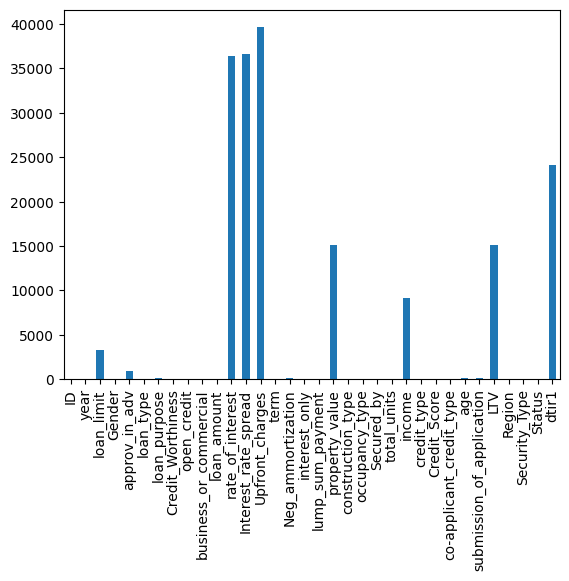

In [6]:
df.isna().sum().plot.bar()
plt.show()

In [7]:
df = df.drop(["ID","year"], axis = "columns")
df.head()

,loan_limit,Gender,approv_in_adv,loan_type,loan_purpose,Credit_Worthiness,open_credit,business_or_commercial,loan_amount,rate_of_interest,...,credit_type,Credit_Score,co-applicant_credit_type,age,submission_of_application,LTV,Region,Security_Type,Status,dtir1
0,cf,Sex Not Available,nopre,type1,p1,l1,nopc,nob/c,116500,NaN,...,EXP,758,CIB,25-34,to_inst,98.728814,south,direct,1,45.0
1,cf,Male,nopre,type2,p1,l1,nopc,b/c,206500,NaN,...,EQUI,552,EXP,55-64,to_inst,NaN,North,direct,1,NaN
2,cf,Male,pre,type1,p1,l1,nopc,nob/c,406500,4.56,...,EXP,834,CIB,35-44,to_inst,80.019685,south,direct,0,46.0
3,cf,Male,nopre,type1,p4,l1,nopc,nob/c,456500,4.25,...,EXP,587,CIB,45-54,not_inst,69.376900,North,direct,0,42.0
4,cf,Joint,pre,type1,p1,l1,nopc,nob/c,696500,4.00,...,CRIF,602,EXP,25-34,not_inst,91.886544,North,direct,0,39.0


In [8]:
df.nunique().sum

<bound method Series.sum of loan_limit                       2
Gender                           4
approv_in_adv                    2
loan_type                        3
loan_purpose                     4
Credit_Worthiness                2
open_credit                      2
business_or_commercial           2
loan_amount                    211
rate_of_interest               131
Interest_rate_spread         22516
Upfront_charges              58271
term                            26
Neg_ammortization                2
interest_only                    2
lump_sum_payment                 2
property_value                 385
construction_type                2
occupancy_type                   3
Secured_by                       2
total_units                      4
income                        1001
credit_type                      4
Credit_Score                   401
co-applicant_credit_type         2
age                              7
submission_of_application        2
LTV                           8484
Region                           4
Security_Type                    2
Status                           2
dtir1                           57
dtype: int64>

In [9]:
cat_vars = []
num_vars = []
for i in df.columns:
    if(df[i].dtype == "object"):
        cat_vars.append(i)
    else:
        num_vars.append(i)
print("Categorical Variables:\n",cat_vars,"\n")
print("Numerical Variables:\n",num_vars,"\n")

Categorical Variables:
 ['loan_limit', 'Gender', 'approv_in_adv', 'loan_type', 'loan_purpose', 'Credit_Worthiness', 'open_credit', 'business_or_commercial', 'Neg_ammortization', 'interest_only', 'lump_sum_payment', 'construction_type', 'occupancy_type', 'Secured_by', 'total_units', 'credit_type', 'co-applicant_credit_type', 'age', 'submission_of_application', 'Region', 'Security_Type'] 

Numerical Variables:
 ['loan_amount', 'rate_of_interest', 'Interest_rate_spread', 'Upfront_charges', 'term', 'property_value', 'income', 'Credit_Score', 'LTV', 'Status', 'dtir1'] 



## Imputing Numerical Variables

In [10]:
df_num = df[num_vars]
knn = KNNImputer(n_neighbors = 3)
knn.fit(df_num)
X = knn.fit_transform(df_num)

In [11]:
X

array([[ 1.16500000e+05,  3.58333333e+00, -3.12666667e-02, ...,
         9.87288136e+01,  1.00000000e+00,  4.50000000e+01],
       [ 2.06500000e+05,  3.70833333e+00,  5.22966667e-01, ...,
         8.47955494e+01,  1.00000000e+00,  3.46666667e+01],
       [ 4.06500000e+05,  4.56000000e+00,  2.00000000e-01, ...,
         8.00196850e+01,  0.00000000e+00,  4.60000000e+01],
       ...,
       [ 4.46500000e+05,  3.12500000e+00,  8.16000000e-02, ...,
         6.13324176e+01,  0.00000000e+00,  4.90000000e+01],
       [ 1.96500000e+05,  3.50000000e+00,  5.82400000e-01, ...,
         7.06834532e+01,  0.00000000e+00,  2.90000000e+01],
       [ 4.06500000e+05,  4.37500000e+00,  1.38710000e+00, ...,
         7.28494624e+01,  0.00000000e+00,  4.40000000e+01]])

In [12]:
df_num = pd.DataFrame(X, columns=num_vars)
df_num.isna().sum()

,0
loan_amount,0
rate_of_interest,0
Interest_rate_spread,0
Upfront_charges,0
term,0
property_value,0
income,0
Credit_Score,0
LTV,0
Status,0


## Imputing Categorical Variables

In [13]:
df_cat = df[cat_vars]
for i in cat_vars:
    mode = df[i].mode()
    mode = mode[0]
    df_cat[i].fillna(value=mode, inplace=True)

df_cat.isna().sum()

,0
loan_limit,0
Gender,0
approv_in_adv,0
loan_type,0
loan_purpose,0
Credit_Worthiness,0
open_credit,0
business_or_commercial,0
Neg_ammortization,0
interest_only,0


In [14]:
df_full = pd.concat([df_num, df_cat], axis=1, join='inner')
df_full.isna().sum()

,0
loan_amount,0
rate_of_interest,0
Interest_rate_spread,0
Upfront_charges,0
term,0
property_value,0
income,0
Credit_Score,0
LTV,0
Status,0


## Outlier Detection and Removal

,0
loan_amount,"Axes(0.125,0.786098;0.352273x0.0939024)"
rate_of_interest,"Axes(0.547727,0.786098;0.352273x0.0939024)"
Interest_rate_spread,"Axes(0.125,0.673415;0.352273x0.0939024)"
Upfront_charges,"Axes(0.547727,0.673415;0.352273x0.0939024)"
term,"Axes(0.125,0.560732;0.352273x0.0939024)"
property_value,"Axes(0.547727,0.560732;0.352273x0.0939024)"
income,"Axes(0.125,0.448049;0.352273x0.0939024)"
Credit_Score,"Axes(0.547727,0.448049;0.352273x0.0939024)"
LTV,"Axes(0.125,0.335366;0.352273x0.0939024)"
Status,"Axes(0.547727,0.335366;0.352273x0.0939024)"


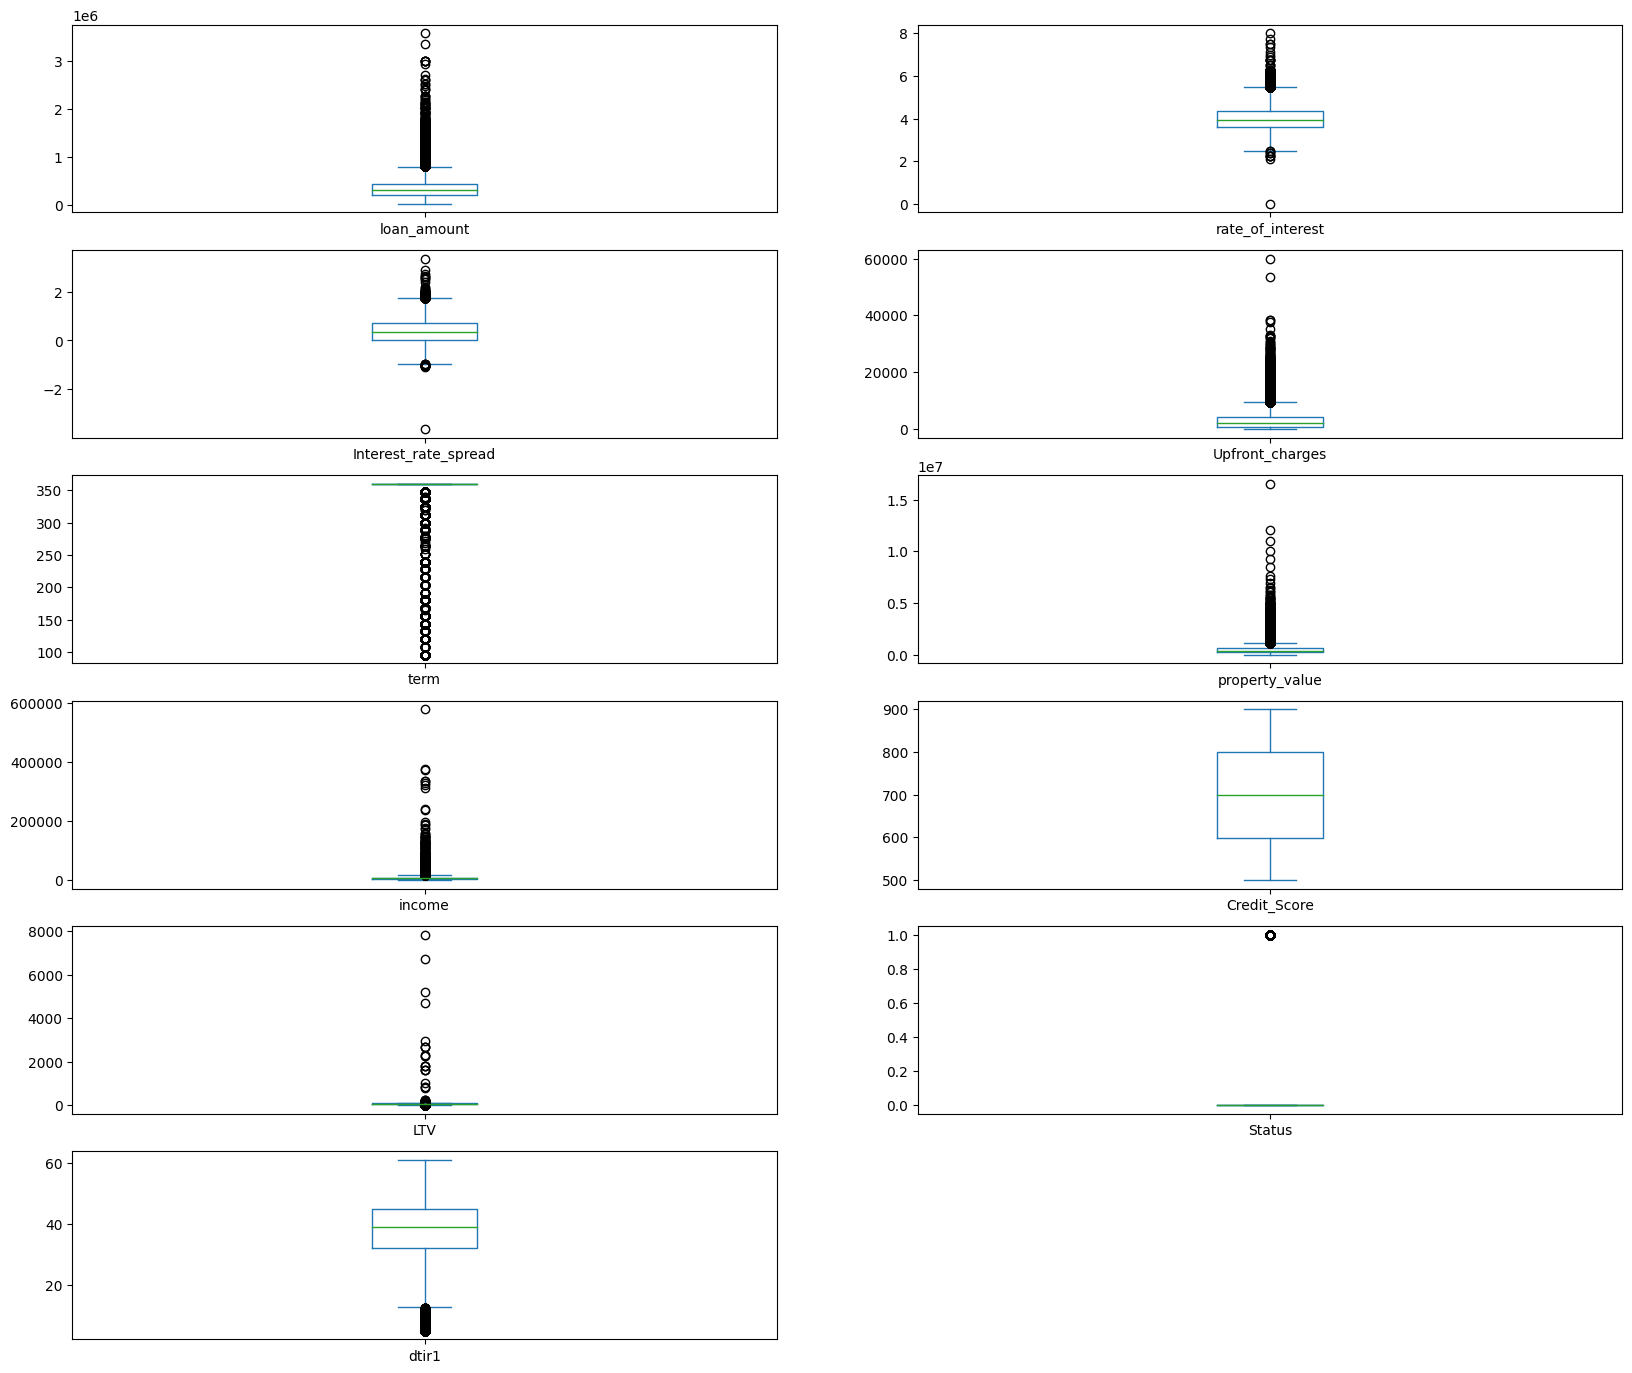

In [15]:
df_full.plot(kind="box",subplots=True,layout=(7,2),figsize=(20,20))

**Inference**: Almost all numerical variables have outliers present except for Credit_Score.

Plots after removing outliers:



,0
loan_amount,"Axes(0.125,0.786098;0.352273x0.0939024)"
rate_of_interest,"Axes(0.547727,0.786098;0.352273x0.0939024)"
Interest_rate_spread,"Axes(0.125,0.673415;0.352273x0.0939024)"
Upfront_charges,"Axes(0.547727,0.673415;0.352273x0.0939024)"
term,"Axes(0.125,0.560732;0.352273x0.0939024)"
property_value,"Axes(0.547727,0.560732;0.352273x0.0939024)"
income,"Axes(0.125,0.448049;0.352273x0.0939024)"
Credit_Score,"Axes(0.547727,0.448049;0.352273x0.0939024)"
LTV,"Axes(0.125,0.335366;0.352273x0.0939024)"
Status,"Axes(0.547727,0.335366;0.352273x0.0939024)"


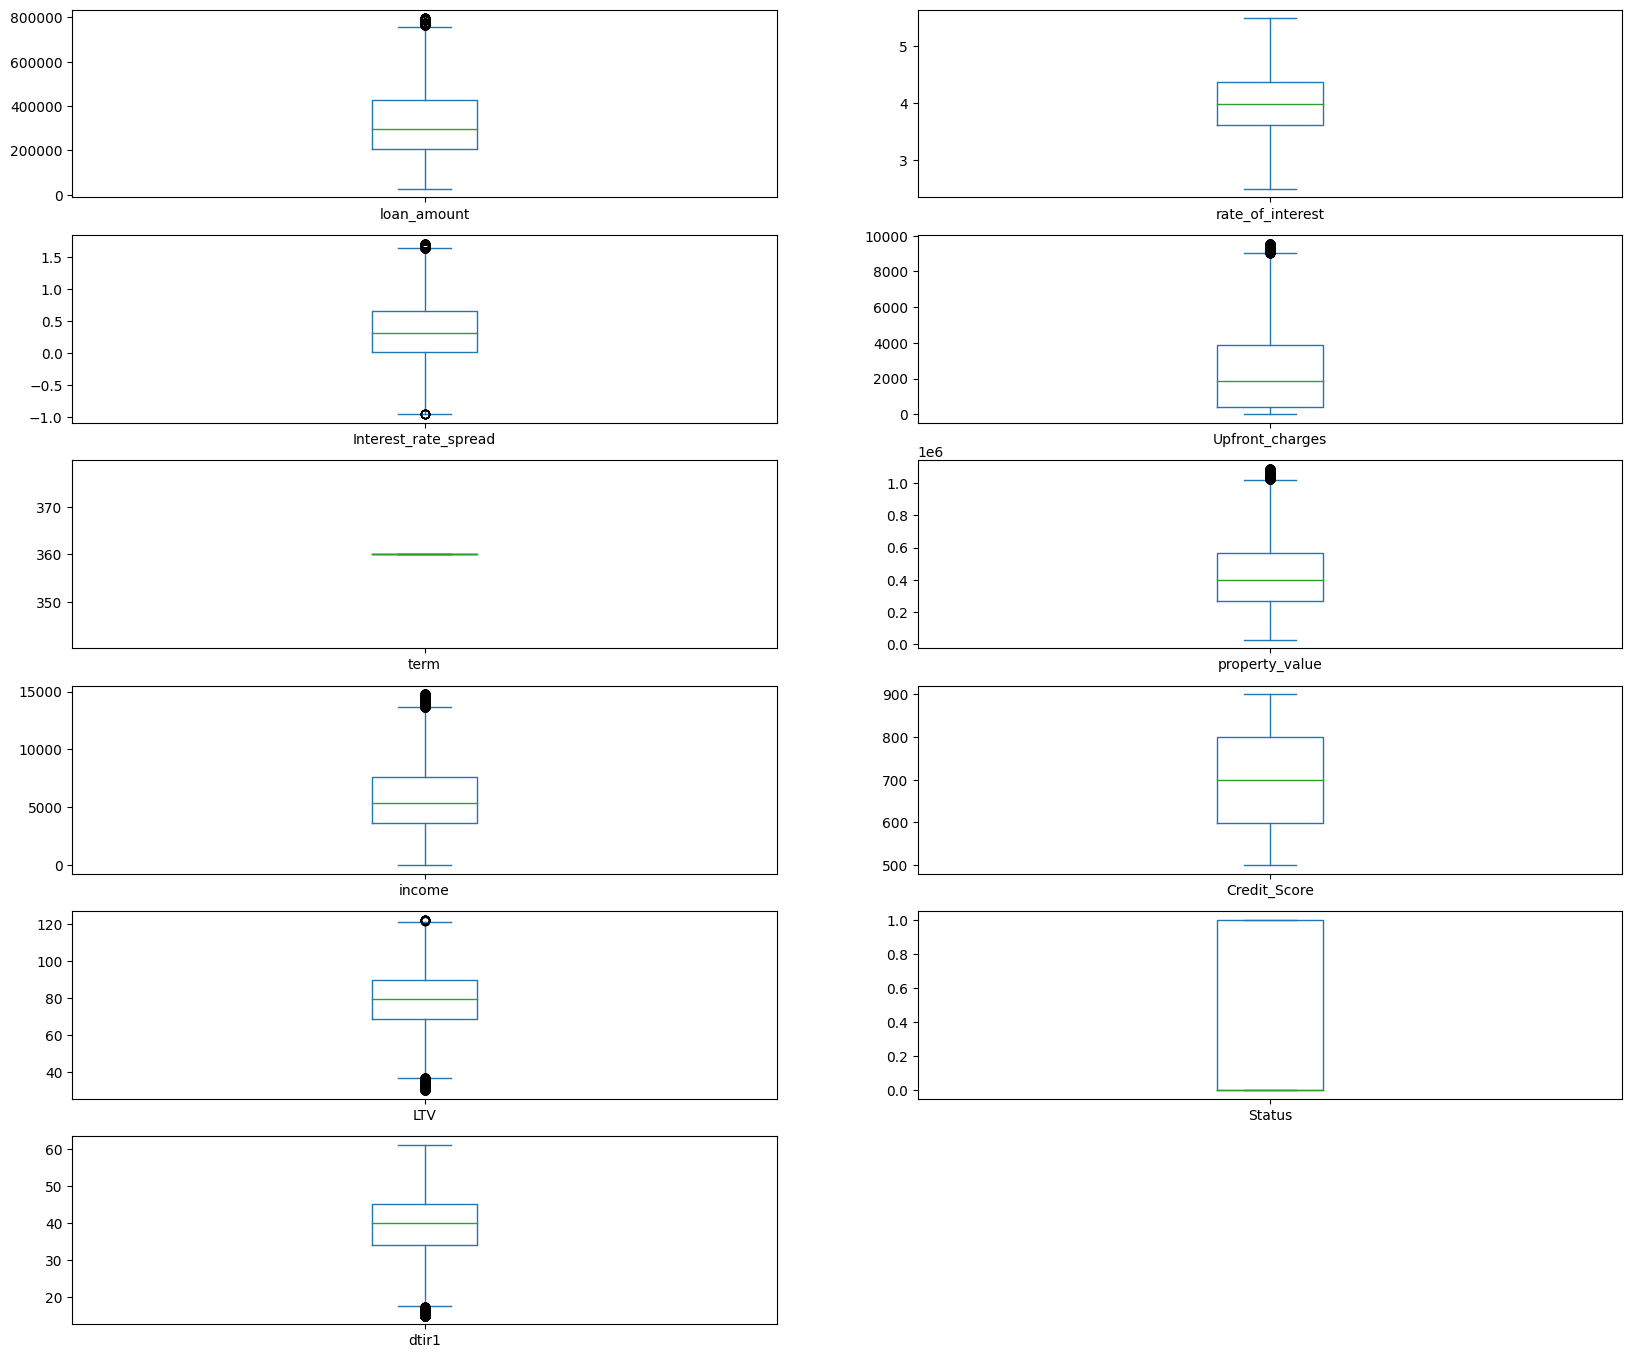

In [16]:
def drop_outliers(df, field_name):
    iqr = 1.5 * (np.percentile(df[field_name], 75) - np.percentile(df[field_name], 25))
    upper_bound = iqr + np.percentile(df[field_name], 75)
    lower_bound = np.percentile(df[field_name], 25) - iqr

    if ((df[field_name] > upper_bound) | (df[field_name] < lower_bound)).empty:
        print("No outliers to drop.")
        return

    df.drop(df[(df[field_name] > upper_bound) | (df[field_name] < lower_bound)].index, inplace=True)

drop_outliers(df_full, "loan_amount")
drop_outliers(df_full, "rate_of_interest")
drop_outliers(df_full, "Interest_rate_spread")
drop_outliers(df_full, "Upfront_charges")
drop_outliers(df_full, "property_value")
drop_outliers(df_full, "income")
drop_outliers(df_full, "LTV")
drop_outliers(df_full, "Status")
drop_outliers(df_full, "term")
drop_outliers(df_full, "dtir1")

print("Plots after removing outliers:\n")
df_full.plot(kind="box", subplots=True, layout=(7,2), figsize=(20,20))

**Inference**: Outliers have been removed.

In [17]:
df_full.shape

(102473, 32)

<Axes: >

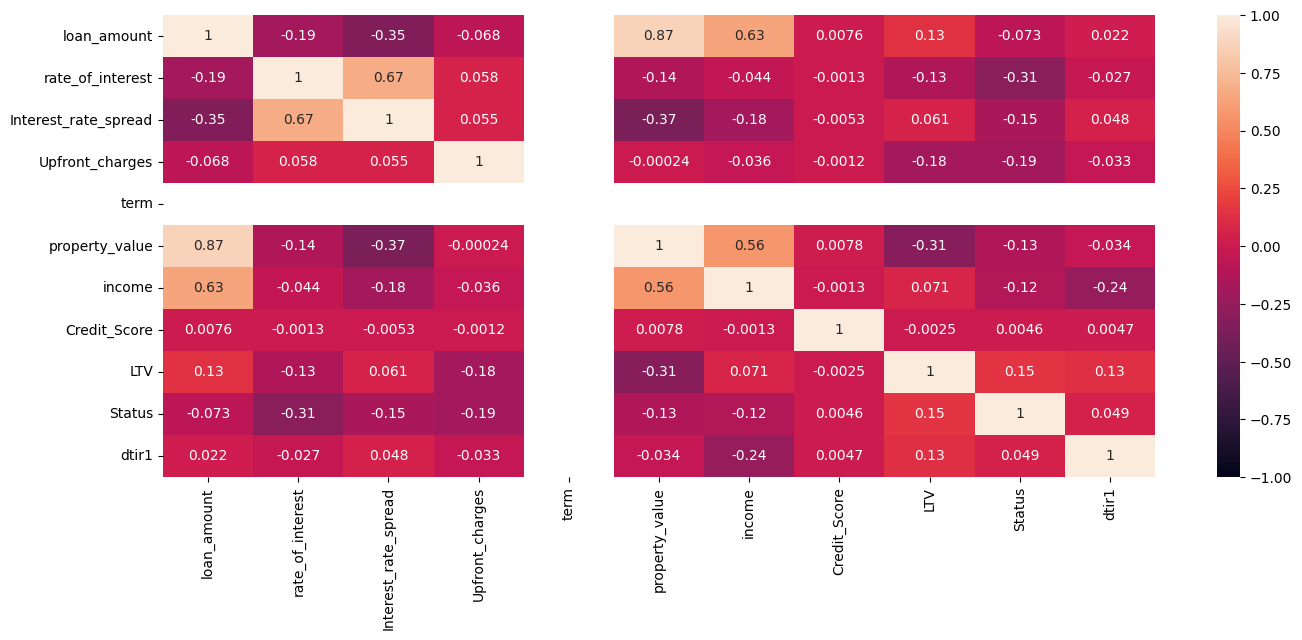

In [18]:
corr = df_full[num_vars].corr()
plt.figure(figsize=(16, 6))
sns.heatmap(data = corr, vmin=-1, vmax=1, annot=True)

**Inference**: High positive Correlation can be seen between property_value and loan_amount

## Encoding Categorical Variables

In [19]:
print(df_full[cat_vars].nunique().sum)

<bound method Series.sum of loan_limit                   2
Gender                       4
approv_in_adv                2
loan_type                    3
loan_purpose                 4
Credit_Worthiness            2
open_credit                  2
business_or_commercial       2
Neg_ammortization            2
interest_only                2
lump_sum_payment             2
construction_type            2
occupancy_type               3
Secured_by                   2
total_units                  4
credit_type                  4
co-applicant_credit_type     2
age                          7
submission_of_application    2
Region                       4
Security_Type                2
dtype: int64>


In [20]:
label = LabelEncoder()
for i in cat_vars:
    df_full[i] = label.fit_transform(df_full[i])

In [21]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Index: 102473 entries, 0 to 148666
Data columns (total 32 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   loan_amount                102473 non-null  float64
 1   rate_of_interest           102473 non-null  float64
 2   Interest_rate_spread       102473 non-null  float64
 3   Upfront_charges            102473 non-null  float64
 4   term                       102473 non-null  float64
 5   property_value             102473 non-null  float64
 6   income                     102473 non-null  float64
 7   Credit_Score               102473 non-null  float64
 8   LTV                        102473 non-null  float64
 9   Status                     102473 non-null  float64
 10  dtir1                      102473 non-null  float64
 11  loan_limit                 102473 non-null  int64  
 12  Gender                     102473 non-null  int64  
 13  approv_in_adv              102473 

**Inference**: Data is cleaned now

## Train Test split

In [22]:
train_set, test_set = train_test_split(df_full, test_size=0.2, random_state=42)

y_train = train_set['Status']
X_train = train_set.drop(columns=['Status'])
y_test = test_set['Status']
X_test = test_set.drop(columns=['Status'])

In [23]:
print("Shape of x_train: ", X_train.shape)
print("Shape of y_train: ", y_train.shape)
print("Shape of x_test: ", X_test.shape)
print("Shape of y_test: ", y_test.shape)

Shape of x_train:  (81978, 31)
Shape of y_train:  (81978,)
Shape of x_test:  (20495, 31)
Shape of y_test:  (20495,)


## Initialzing Boosting Models

In [24]:
gdb = GradientBoostingClassifier(random_state = 42)
adab = AdaBoostClassifier(random_state = 42)
lgb = LGBMClassifier(random_state = 42)
catb = CatBoostClassifier(random_state = 42)
xgb = XGBClassifier(random_state = 42)

## Gradient Boosting

In [25]:
gdb.fit(X_train, y_train)
y_pred_gdb = gdb.predict(X_test)
print('Accuracy :',accuracy_score(y_test, y_pred_gdb))
print("\n")
print(classification_report(y_test, y_pred_gdb))

Accuracy : 0.9369114418150768


              precision    recall  f1-score   support

         0.0       0.93      0.99      0.96     15339
         1.0       0.97      0.77      0.86      5156

    accuracy                           0.94     20495
   macro avg       0.95      0.88      0.91     20495
weighted avg       0.94      0.94      0.93     20495



## XGBoost

In [26]:
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
print('Accuracy :',accuracy_score(y_test, y_pred_xgb))
print("\n")
print(classification_report(y_test, y_pred_xgb))

Accuracy : 0.9754574286411319


              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98     15339
         1.0       0.98      0.92      0.95      5156

    accuracy                           0.98     20495
   macro avg       0.98      0.96      0.97     20495
weighted avg       0.98      0.98      0.98     20495



Using **SelectFromModel** approach on XGBoost to select features with specified threshold of importance

In [27]:
from sklearn.feature_selection import SelectFromModel
sfm = SelectFromModel(xgb)

xgb2 = sfm.fit(X_train, y_train)
selected_features = X_train.columns[sfm.get_support()]
print(selected_features)

Index(['rate_of_interest', 'loan_type', 'Neg_ammortization',
       'lump_sum_payment', 'credit_type', 'submission_of_application'],
      dtype='object')


## Light GBM

In [28]:
lgb.fit(X_train, y_train)
y_pred_lgb = lgb.predict(X_test)
print('Accuracy :',accuracy_score(y_test, y_pred_lgb))
print("\n")
print(classification_report(y_test, y_pred_lgb))

[LightGBM] [Info] Number of positive: 20577, number of negative: 61401
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026532 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1901
[LightGBM] [Info] Number of data points in the train set: 81978, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.251006 -> initscore=-1.093252
[LightGBM] [Info] Start training from score -1.093252
Accuracy : 0.9807757989753598


              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99     15339
         1.0       0.99      0.93      0.96      5156

    accuracy                           0.98     20495
   macro avg       0.98      0.97      0.97     20495
weighted avg       0.98      0.98      0.98     20495



## Cat Boost

In [29]:
catb.fit(X_train, y_train)
y_pred_catb = catb.predict(X_test)
print('Accuracy :',accuracy_score(y_test, y_pred_catb))
print("\n")
print(classification_report(y_test, y_pred_catb))

Learning rate set to 0.067621
0:	learn: 0.6194585	total: 82.9ms	remaining: 1m 22s
1:	learn: 0.5619468	total: 112ms	remaining: 55.7s
2:	learn: 0.5273263	total: 136ms	remaining: 45.1s
3:	learn: 0.4999893	total: 159ms	remaining: 39.6s
4:	learn: 0.4751773	total: 186ms	remaining: 37.1s
5:	learn: 0.4530349	total: 211ms	remaining: 34.9s
6:	learn: 0.4239136	total: 234ms	remaining: 33.2s
7:	learn: 0.3981604	total: 262ms	remaining: 32.5s
8:	learn: 0.3834119	total: 284ms	remaining: 31.3s
9:	learn: 0.3718267	total: 309ms	remaining: 30.6s
10:	learn: 0.3558497	total: 333ms	remaining: 29.9s
11:	learn: 0.3457313	total: 364ms	remaining: 30s
12:	learn: 0.3354220	total: 392ms	remaining: 29.8s
13:	learn: 0.3277183	total: 415ms	remaining: 29.2s
14:	learn: 0.3201627	total: 437ms	remaining: 28.7s
15:	learn: 0.3085830	total: 463ms	remaining: 28.5s
16:	learn: 0.3016049	total: 486ms	remaining: 28.1s
17:	learn: 0.2965980	total: 508ms	remaining: 27.7s
18:	learn: 0.2908001	total: 531ms	remaining: 27.4s
19:	learn: 

## Ada Boost

In [31]:
from sklearn.tree import DecisionTreeClassifier
base_classifier = DecisionTreeClassifier(max_depth=1)
adab = AdaBoostClassifier(estimator=base_classifier, random_state=42)
adab.fit(X_train, y_train)
y_pred_adab = adab.predict(X_test)
print('Accuracy :',accuracy_score(y_test, y_pred_adab))
print("\n")
print(classification_report(y_test, y_pred_adab))

Accuracy : 0.9050500121980971


              precision    recall  f1-score   support

         0.0       0.91      0.97      0.94     15339
         1.0       0.90      0.70      0.79      5156

    accuracy                           0.91     20495
   macro avg       0.90      0.84      0.86     20495
weighted avg       0.90      0.91      0.90     20495



## Compiling Models Scores

In [32]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

trained_models = [adab, gdb, xgb, lgb, catb]
model_names = ["AdaBoost","GradientBoost","XGBoost","LGBoost","CatBoost"]
model_list = list(zip(model_names, trained_models))
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

for model_name, model in model_list:
    y_pred = model.predict(X_test)

    accuracy_scores.append(accuracy_score(y_test, y_pred))
    precision_scores.append(precision_score(y_test, y_pred))
    recall_scores.append(recall_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred))

metrics_df = pd.DataFrame({
    'Model': model_names,
    'Accuracy': accuracy_scores,
    'Precision': precision_scores,
    'Recall': recall_scores,
    'F1-Score': f1_scores
})

metrics_df

,Model,Accuracy,Precision,Recall,F1-Score
0,AdaBoost,0.905050,0.902659,0.697828,0.787136
1,GradientBoost,0.936911,0.973988,0.769783,0.859929
2,XGBoost,0.975457,0.977427,0.923778,0.949845
3,LGBoost,0.980776,0.988510,0.934445,0.960718
4,CatBoost,0.984582,0.989284,0.948991,0.968719


**Inference**: All the evaluation metrics values are increasing with each successive boosting model with best results given by CatBoost. Catboost is already giving accuracy of 98% so there is no need for stacking or hyperparametertuning.